# Evaluating Efficiency and Purity

This notebook demonstrates how to evaluate efficiency and purity using the data products of the detection pipeline.

Efficiency and puristy are defined as:

- Efficiency (recall) = True Positives / (True Positives + False Negatives)

- Purity (precision) = True Positives / (True Positives + False Positives)


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def correct_truth_mag(mag, band):
    """
    Convert mag from Roman truth table to zero-pointed truth mag.
    
    AREA_EFF is obtained through the following code.
        from galsim import roman
        roman.collecting_area
    """

    AREA_EFF = 37570.0
    EXPTIME = {'F184': 901.175,
               'J129': 302.275,
               'H158': 302.275,
               'K213': 901.175,
               'R062': 161.025,
               'Y106': 302.275,
               'Z087': 101.7}

    zpt_mag = 2.5 * np.log10(EXPTIME[band] * AREA_EFF)
    zeropointed_truth_mag = mag + zpt_mag
    return zeropointed_truth_mag

In [5]:
data_records = pd.read_csv('../test/test_ten_data_records.csv')

In [6]:
output_dir = '../../test_output' # output_dir of the detection
DIFF_PATTERN = '{science_band}_{science_pointing}_{science_sca}_-_{template_band}_{template_pointing}_{template_sca}'


full_transients_to_detection = pd.DataFrame()
full_detection_to_transients = pd.DataFrame()

for i, row in data_records.iterrows():
    diff_pattern = DIFF_PATTERN.format(science_band=row['science_band'],
                                   science_pointing=row['science_pointing'],
                                   science_sca=row['science_sca'],
                                   template_band=row['template_band'],
                                   template_pointing=row['template_pointing'],
                                   template_sca=row['template_sca'])
    full_dir = os.path.join(output_dir, diff_pattern)
    transients_to_detection_name = f'transients_to_detection_{diff_pattern}.csv'
    detection_to_transients_name = f'detection_to_transients_{diff_pattern}.csv'

    transients_to_detection_path = os.path.join(output_dir, diff_pattern, transients_to_detection_name)
    detection_to_transients_path = os.path.join(output_dir, diff_pattern, detection_to_transients_name)

    transients_to_detection = pd.read_csv(transients_to_detection_path)
    detection_to_transients = pd.read_csv(detection_to_transients_path)
    
    full_transients_to_detection = pd.concat([full_transients_to_detection, transients_to_detection], ignore_index=True)
    full_detection_to_transients = pd.concat([full_detection_to_transients, detection_to_transients], ignore_index=True)

In [7]:
efficiency = full_transients_to_detection.matched_status.sum() / len(full_transients_to_detection)
purity = full_detection_to_transients.matched_status.sum() / len(full_detection_to_transients)
print(f'Efficiency: {efficiency:.3f}, Purity: {purity:.3f}')

Efficiency: 0.068, Purity: 0.003


We also want to know the efficiency in each magnitude bin.

/tmp/ipykernel_1785481/260064890.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  effs = full_transients_to_detection.groupby('mag_bin')['matched_status'].agg(['sum', 'count']).reset_index()


Text(0, 0.5, 'Efficiency')

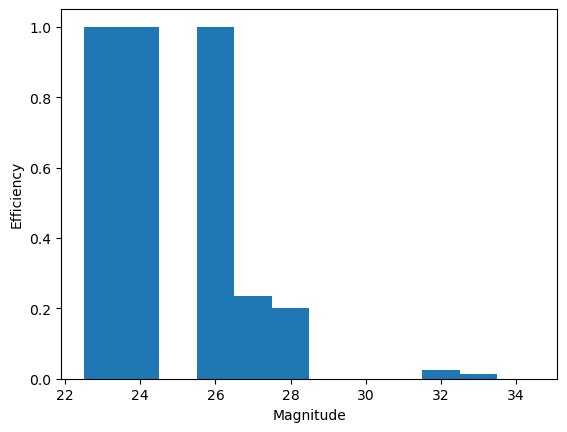

In [8]:
full_transients_to_detection['zero_pointed_mag'] = correct_truth_mag(full_transients_to_detection.mag, 'H158')

mag_bins = np.arange(np.floor(full_transients_to_detection.zero_pointed_mag.min()), np.ceil(full_transients_to_detection.zero_pointed_mag.max()) + 1, 1)
mag_labels = mag_bins[:-1] + 0.5
full_transients_to_detection['mag_bin'] = pd.cut(full_transients_to_detection.zero_pointed_mag, bins=mag_bins, labels=mag_labels, include_lowest=True)
effs = full_transients_to_detection.groupby('mag_bin')['matched_status'].agg(['sum', 'count']).reset_index()
effs['efficiency'] = effs['sum'] / effs['count']
plt.bar(effs['mag_bin'], effs['efficiency'], width=np.diff(mag_bins), align='edge')
plt.xlabel('Magnitude')
plt.ylabel('Efficiency')